In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)


Using: cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)


In [3]:
class MLP(nn.Module):
    def __init__(self, layers, activation="relu"):
        super().__init__()
        self.layers = nn.ModuleList()
        acts = {
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "tanh": nn.Tanh()
        }
        self.act = acts[activation]

        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        return self.layers[-1](x)


In [17]:
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(x)          # shape [batch, 10]
        loss = loss_fn(outputs, y)  # y shape [batch]

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


In [18]:
model = MLP([784, 128, 64, 10], "relu").to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

losses = []
for epoch in range(10):
    loss = train_epoch(model, train_loader, optimizer, loss_fn)
    acc = test(model, test_loader)
    losses.append(loss)
    print(f"Epoch {epoch+1}: loss={loss:.4f}, test_acc={acc:.4f}")


Epoch 1: loss=0.4359, test_acc=0.9394
Epoch 2: loss=0.1794, test_acc=0.9579
Epoch 3: loss=0.1223, test_acc=0.9672
Epoch 4: loss=0.0926, test_acc=0.9709
Epoch 5: loss=0.0728, test_acc=0.9742
Epoch 6: loss=0.0584, test_acc=0.9757
Epoch 7: loss=0.0476, test_acc=0.9758
Epoch 8: loss=0.0388, test_acc=0.9746
Epoch 9: loss=0.0328, test_acc=0.9753
Epoch 10: loss=0.0280, test_acc=0.9777


In [20]:
activations = ["relu", "sigmoid", "tanh"]
all_losses = {}
final_acc = {}

for act in activations:
    model = MLP([784,128,64,10], act).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    for _ in range(10):
        losses.append(train_epoch(model, train_loader, optimizer, loss_fn))
    all_losses[act] = losses
    final_acc[act] = test(model, test_loader)


In [21]:
for act, acc in final_acc.items():
    print(f"{act}: {acc:.4f}")


relu: 0.9778
sigmoid: 0.9719
tanh: 0.9760


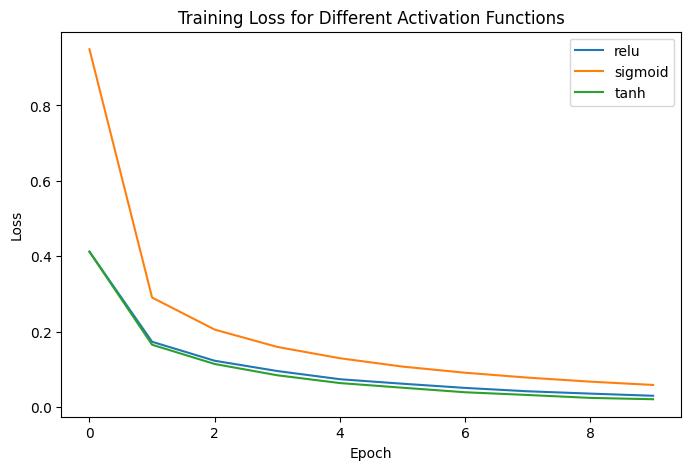

In [22]:
plt.figure(figsize=(8,5))
for act, losses in all_losses.items():
    plt.plot(losses, label=act)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Activation Functions")
plt.savefig("activation_loss.png")
plt.show()


In [23]:
X = torch.tensor([[0.,0.],[0.,1.],[1.,0.],[1.,1.]]).to(device)
y = torch.tensor([[0.],[1.],[1.],[0.]]).to(device)

xor_model = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1),
    nn.Sigmoid()
).to(device)

optimizer = torch.optim.Adam(xor_model.parameters(), lr=0.1)
loss_fn = nn.BCELoss()

for _ in range(2000):
    optimizer.zero_grad()
    loss = loss_fn(xor_model(X), y)
    loss.backward()
    optimizer.step()

print("Predictions:", (xor_model(X) > 0.5).int().cpu().numpy())


Predictions: [[0]
 [1]
 [1]
 [0]]


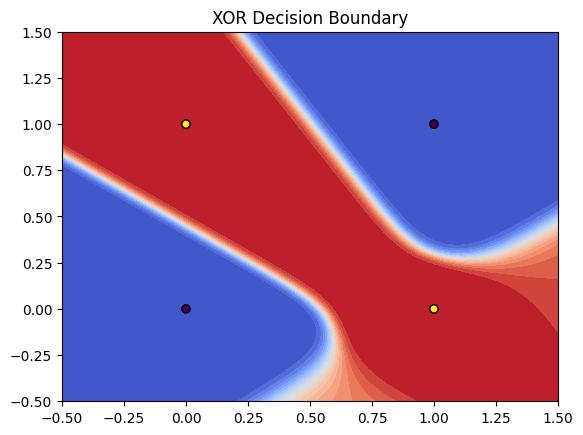

In [24]:
import numpy as np

xx, yy = np.meshgrid(np.linspace(-0.5,1.5,200), np.linspace(-0.5,1.5,200))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

with torch.no_grad():
    preds = xor_model(grid).cpu().numpy().reshape(xx.shape)

plt.contourf(xx, yy, preds, levels=20, cmap="coolwarm")
plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.cpu().flatten(), edgecolors='k')
plt.title("XOR Decision Boundary")
plt.show()


In [27]:
loss_fn = nn.CrossEntropyLoss()


In [29]:
import time

optimizers = {
    "SGD": lambda p: torch.optim.SGD(p, lr=0.01),
    "SGD+Momentum": lambda p: torch.optim.SGD(p, lr=0.01, momentum=0.9),
    "RMSprop": lambda p: torch.optim.RMSprop(p, lr=0.001),
    "Adam": lambda p: torch.optim.Adam(p, lr=0.001),
}

opt_losses = {}
opt_accs = {}
opt_times = {}

for name, opt_fn in optimizers.items():
    print("\nRunning:", name)
    model = MLP([784,128,64,10], "relu").to(device)
    optimizer = opt_fn(model.parameters())

    losses = []
    accs = []

    start = time.time()
    for epoch in range(20):
        loss = train_epoch(model, train_loader, optimizer, loss_fn)
        acc = test(model, test_loader)
        losses.append(loss)
        accs.append(acc)
        print(f"Epoch {epoch+1}: loss={loss:.4f}, acc={acc:.4f}")

    opt_losses[name] = losses
    opt_accs[name] = accs
    opt_times[name] = time.time() - start



Running: SGD
Epoch 1: loss=2.1813, acc=0.5266
Epoch 2: loss=1.3853, acc=0.7885
Epoch 3: loss=0.7020, acc=0.8535
Epoch 4: loss=0.5046, acc=0.8782
Epoch 5: loss=0.4308, acc=0.8874
Epoch 6: loss=0.3929, acc=0.8934
Epoch 7: loss=0.3684, acc=0.8988
Epoch 8: loss=0.3507, acc=0.9032
Epoch 9: loss=0.3365, acc=0.9072
Epoch 10: loss=0.3240, acc=0.9100
Epoch 11: loss=0.3131, acc=0.9137
Epoch 12: loss=0.3027, acc=0.9161
Epoch 13: loss=0.2927, acc=0.9209
Epoch 14: loss=0.2832, acc=0.9220
Epoch 15: loss=0.2742, acc=0.9226
Epoch 16: loss=0.2658, acc=0.9266
Epoch 17: loss=0.2578, acc=0.9289
Epoch 18: loss=0.2500, acc=0.9304
Epoch 19: loss=0.2426, acc=0.9330
Epoch 20: loss=0.2358, acc=0.9352

Running: SGD+Momentum
Epoch 1: loss=0.7584, acc=0.9075
Epoch 2: loss=0.2798, acc=0.9305
Epoch 3: loss=0.2127, acc=0.9476
Epoch 4: loss=0.1690, acc=0.9530
Epoch 5: loss=0.1377, acc=0.9615
Epoch 6: loss=0.1135, acc=0.9658
Epoch 7: loss=0.0982, acc=0.9691
Epoch 8: loss=0.0842, acc=0.9706
Epoch 9: loss=0.0747, acc=0.

In [17]:
plt.figure(figsize=(8,5))
for name, losses in opt_losses.items():
    plt.plot(losses, label=name)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Optimizer Comparison — Training Loss")
plt.savefig("optimizer_loss.png")
plt.show()


NameError: name 'opt_losses' is not defined

<Figure size 800x500 with 0 Axes>

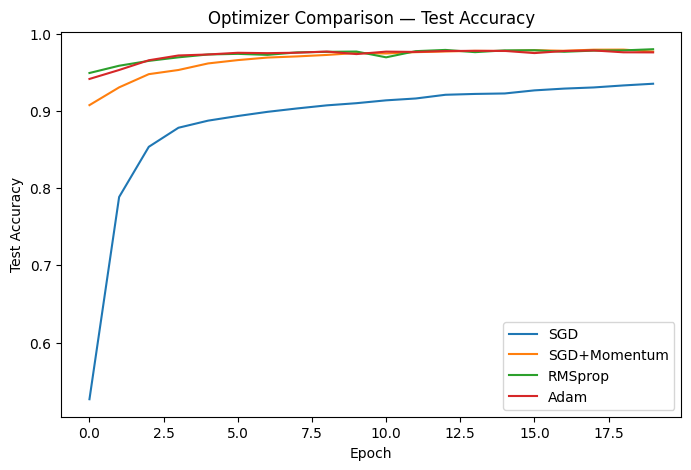

In [31]:
plt.figure(figsize=(8,5))
for name, accs in opt_accs.items():
    plt.plot(accs, label=name)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Optimizer Comparison — Test Accuracy")
plt.savefig("optimizer_accuracy.png")
plt.show()


In [ ]:
print("Optimizer | Final Acc | Time (sec)")
print("-"*35)
for name in optimizers:
    print(f"{name:14} | {opt_accs[name][-1]:.4f} | {opt_times[name]:.2f}")


Optimizer | Final Acc | Time (sec)
-----------------------------------
SGD            | 0.9352 | 137.88
SGD+Momentum   | 0.9768 | 81.31
RMSprop        | 0.9799 | 92.74
Adam           | 0.9758 | 121.34


In [33]:
class DeepMLP(nn.Module):
    def __init__(self, activation):
        super().__init__()
        act = nn.Sigmoid() if activation == "sigmoid" else nn.ReLU()

        layers = [nn.Linear(784, 256)]
        for _ in range(5):
            layers += [act, nn.Linear(256, 256)]
        layers += [act, nn.Linear(256, 10)]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [34]:
def get_gradients(activation):
    model = DeepMLP(activation).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    x, y = next(iter(train_loader))
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    loss = loss_fn(model(x), y)
    loss.backward()

    grads = [p.grad.abs().mean().item() for p in model.parameters() if p.grad is not None]
    return grads

sigmoid_grads = get_gradients("sigmoid")
relu_grads = get_gradients("relu")


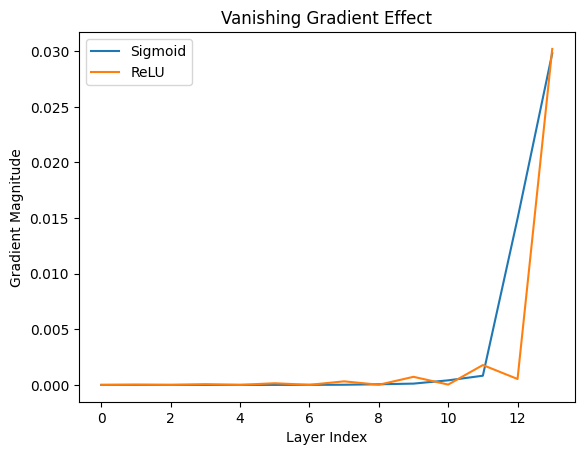

In [35]:
plt.plot(sigmoid_grads, label="Sigmoid")
plt.plot(relu_grads, label="ReLU")
plt.xlabel("Layer Index")
plt.ylabel("Gradient Magnitude")
plt.title("Vanishing Gradient Effect")
plt.legend()
plt.savefig("vanishing_gradient.png")
plt.show()


In [36]:
configs = {
    "No Reg": lambda: MLP([784,128,64,10], "relu"),
    "L2": lambda: MLP([784,128,64,10], "relu"),
    "Dropout": lambda: nn.Sequential(
        nn.Linear(784,128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64,10)
    )
}

reg_results = {}

for name, model_fn in configs.items():
    model = model_fn().to(device)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.001,
        weight_decay=0.001 if name == "L2" else 0
    )

    train_accs = []
    test_accs = []

    for _ in range(10):
        train_epoch(model, train_loader, optimizer, loss_fn)
        train_accs.append(test(model, train_loader))
        test_accs.append(test(model, test_loader))

    reg_results[name] = (train_accs, test_accs)


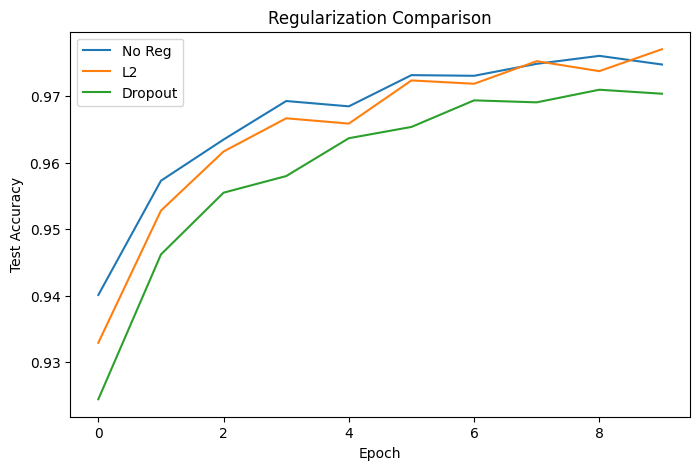

In [37]:
plt.figure(figsize=(8,5))
for name, (train_a, test_a) in reg_results.items():
    plt.plot(test_a, label=name)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Regularization Comparison")
plt.savefig("regularization.png")
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False)

classes = trainset.classes


100%|██████████| 170M/170M [00:26<00:00, 6.42MB/s] 
c:\Users\Амир\Desktop\hw_dl_1\venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [6]:
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def test(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_accs = []

for epoch in range(20):
    loss = train_epoch(model, train_loader, optimizer, loss_fn)
    acc = test(model, test_loader)

    train_losses.append(loss)
    test_accs.append(acc)

    print(f"Epoch {epoch+1}: loss={loss:.4f}, test_acc={acc:.4f}")


Epoch 1: loss=1.4136, test_acc=0.5978
Epoch 2: loss=1.0516, test_acc=0.6582
Epoch 3: loss=0.8952, test_acc=0.6881
Epoch 4: loss=0.7803, test_acc=0.6865
Epoch 5: loss=0.6910, test_acc=0.7110
Epoch 6: loss=0.6147, test_acc=0.7238
Epoch 7: loss=0.5334, test_acc=0.7181
Epoch 8: loss=0.4568, test_acc=0.7137
Epoch 9: loss=0.3896, test_acc=0.7168
Epoch 10: loss=0.3196, test_acc=0.7202
Epoch 11: loss=0.2580, test_acc=0.7191
Epoch 12: loss=0.2059, test_acc=0.7039
Epoch 13: loss=0.1588, test_acc=0.7135
Epoch 14: loss=0.1261, test_acc=0.7115
Epoch 15: loss=0.0985, test_acc=0.7120
Epoch 16: loss=0.0733, test_acc=0.7087
Epoch 17: loss=0.0741, test_acc=0.7105
Epoch 18: loss=0.0634, test_acc=0.7119
Epoch 19: loss=0.0712, test_acc=0.6969
Epoch 20: loss=0.0601, test_acc=0.7032


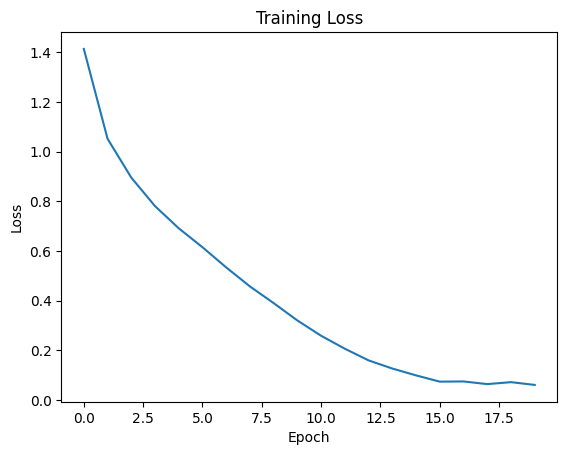

In [10]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


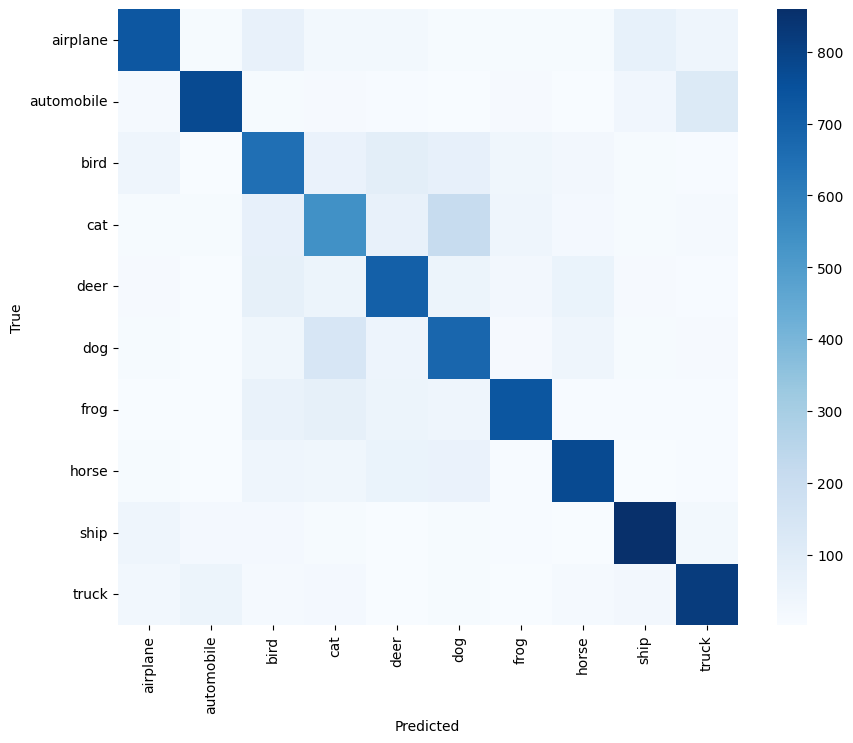

In [20]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, xticklabels=classes,
            yticklabels=classes, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [11]:
class CNN_A(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [12]:
class CNN_B(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [13]:
class CNN_C(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)

        self.pool = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [14]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())


In [15]:
import time

def train_model(model, epochs=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    start = time.time()
    for _ in range(epochs):
        train_epoch(model, train_loader, optimizer, loss_fn)
    duration = time.time() - start

    acc = test(model, test_loader)
    return acc, duration


In [18]:
models = {
    "CNN_A (Baseline)": CNN_A(),
    "CNN_B (Deeper)": CNN_B(),
    "CNN_C (AvgPool)": CNN_C()
}

results = []

for name, model in models.items():
    acc, time_spent = train_model(model)
    params = count_params(model)

    results.append([name, params, round(time_spent,2), round(acc,4)])
    print(name, "done")


CNN_A (Baseline) done
CNN_B (Deeper) done
CNN_C (AvgPool) done


In [19]:
import pandas as pd

df = pd.DataFrame(
    results,
    columns=["Architecture", "Parameters", "Training Time (s)", "Test Accuracy"]
)

df


,Architecture,Parameters,Training Time (s),Test Accuracy
0,CNN_A (Baseline),545098,374.31,0.7187
1,CNN_B (Deeper),1080042,312.92,0.7379
2,CNN_C (AvgPool),1259786,646.17,0.7253


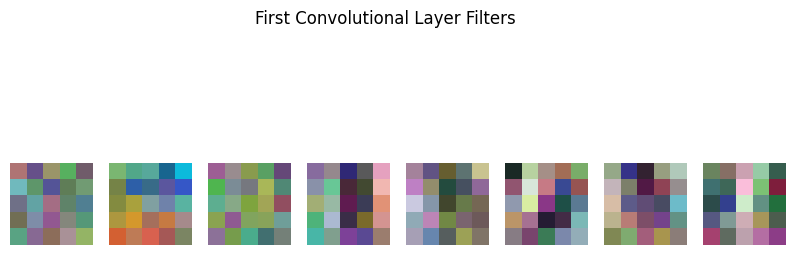

In [21]:
# Get first conv layer weights
weights = model.conv1.weight.data.cpu()

# Normalize for visualization
weights = (weights - weights.min()) / (weights.max() - weights.min())

plt.figure(figsize=(10,4))

for i in range(8):
    plt.subplot(1, 8, i+1)
    kernel = weights[i]
    kernel = kernel.permute(1, 2, 0)  # CHW -> HWC
    plt.imshow(kernel)
    plt.axis("off")

plt.suptitle("First Convolutional Layer Filters")
plt.show()


In [22]:
activation = {}

def hook_fn(module, input, output):
    activation['conv1'] = output.detach()

handle = model.conv1.register_forward_hook(hook_fn)


In [23]:
images, labels = next(iter(test_loader))
images = images.to(device)

_ = model(images)
act_maps = activation['conv1'].cpu()


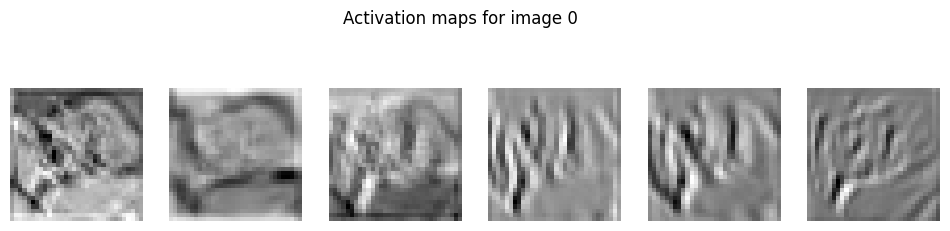

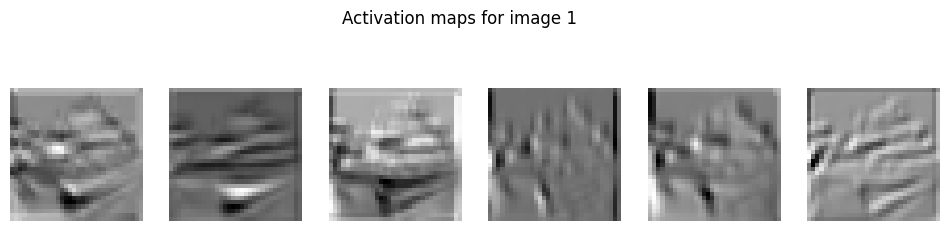

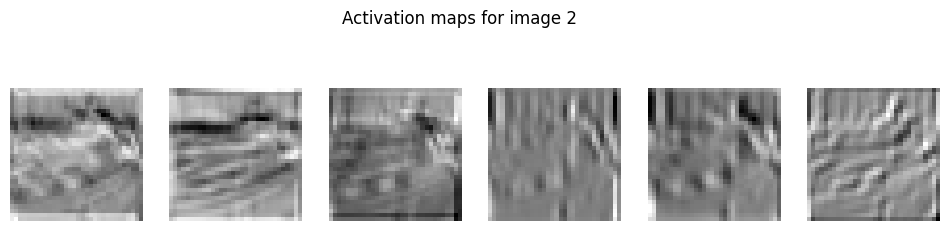

In [25]:
num_maps = 6  # show 6 feature maps

for img_idx in range(3):
    plt.figure(figsize=(12,3))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i+1)
        plt.imshow(act_maps[img_idx, i], cmap='gray')
        plt.axis("off")
    plt.suptitle(f"Activation maps for image {img_idx}")
    plt.show()
